In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

This is the csv file of the merged dataset

In [31]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


here we dropped the **customerID** temporary due to the formation of this column differ in the two dataset we merged together

In [32]:
df.drop(columns=['customerID'] , inplace = True)

In [33]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Dataset Overview & Preprocessing Needs
The dataset consists of 9,941 entries with 21 columns, containing customer-related information. The data includes categorical and numerical features such as customer demographics, service subscriptions, contract details, and billing information. The target variable, "Churn", indicates whether a customer has left the service.

All columns have non-null values, but "TotalCharges" is stored as an object type instead of a numerical type, so this column require preprocessing.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9941 entries, 0 to 9940
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            9941 non-null   object 
 1   SeniorCitizen     9941 non-null   int64  
 2   Partner           9941 non-null   object 
 3   Dependents        9941 non-null   object 
 4   tenure            9941 non-null   int64  
 5   PhoneService      9941 non-null   object 
 6   MultipleLines     9941 non-null   object 
 7   InternetService   9941 non-null   object 
 8   OnlineSecurity    9941 non-null   object 
 9   OnlineBackup      9941 non-null   object 
 10  DeviceProtection  9941 non-null   object 
 11  TechSupport       9941 non-null   object 
 12  StreamingTV       9941 non-null   object 
 13  StreamingMovies   9941 non-null   object 
 14  Contract          9941 non-null   object 
 15  PaperlessBilling  9941 non-null   object 
 16  PaymentMethod     9941 non-null   object 


**converts "TotalCharges" to a numeric type**

In [35]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Handling Missing Values in TotalCharges
-We observed that all NaN values in **TotalCharges** belong to **non-churned customers** with a **tenure of 0**, yet they have **MonthlyCharges** values. This indicates that these are **not errors**, but rather customers who have just signed up with the company and haven't accumulated any total charges yet, so we fill it with the **corresponding** **MonthlyCharges** value

In [36]:
df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)

<ipython-input-36-4cdf190eed76>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)


# Statistical Summary of Key Numerical Features
**Statistical Summary of Key Numerical Features:**

**SeniorCitizen:** A binary feature (0 or 1) indicating whether a customer is a senior citizen. About 26% of the customers are senior citizens.

**Tenure:** The average tenure of customers is approximately 33.64 months, with a maximum of 72 months and a minimum of 0 months (new customers).

**MonthlyCharges:** Customers pay an average of \$66.46 per month, with charges ranging from \$18.25 to \$119.99.

**TotalCharges:** The total amount paid by customers varies significantly, with an average of \$2,374.11 and a maximum of \$8,684.80. The count is 9,930, indicating that some values were missing or coerced to NaN during preprocessing.

In [37]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,9941.000000,9941.000000,9941.000000,9941.000000
mean,0.260135,33.642290,66.462251,2371.525187
std,0.438730,23.622109,29.795104,2171.714732
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,11.000000,41.900000,549.920000
50%,0.000000,32.000000,70.370000,1654.850000
75%,1.000000,55.000000,90.890000,3795.450000
max,1.000000,72.000000,119.990000,8684.800000


# Outlier Analysis
we find that there is no outliers in **MonthlyCharges** and **tenure** and there is only one outlier sample in the **TotalChareges** values

In [38]:
# Using IQR to detect outliers
Q1 = df[['TotalCharges', 'MonthlyCharges', 'tenure']].quantile(0.25)
Q3 = df[['TotalCharges', 'MonthlyCharges', 'tenure']].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[['TotalCharges', 'MonthlyCharges', 'tenure']] < (Q1 - 1.5 * IQR)) |
            (df[['TotalCharges', 'MonthlyCharges', 'tenure']] > (Q3 + 1.5 * IQR)))
print(outliers.sum())
print(IQR)


TotalCharges      3
MonthlyCharges    0
tenure            0
dtype: int64
TotalCharges      3245.53
MonthlyCharges      48.99
tenure              44.00
dtype: float64


we noticed after the merging of the two datasets that there is a 22 duplicated samples

In [39]:
df.duplicated().sum()

22

In [40]:
df = df.drop_duplicates()

The **Churn** column contains categorical values ("Yes" and "No"), which need to be converted into numerical format

In [41]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

# Impact of Merging on Feature Correlation
Before merging the two datasets, we found that the correlation between features was extremely low, not exceeding 0.01, making it impossible to derive meaningful insights. However, after merging, we observed a positive indication, suggesting that the combined data holds valuable patterns worth exploring!

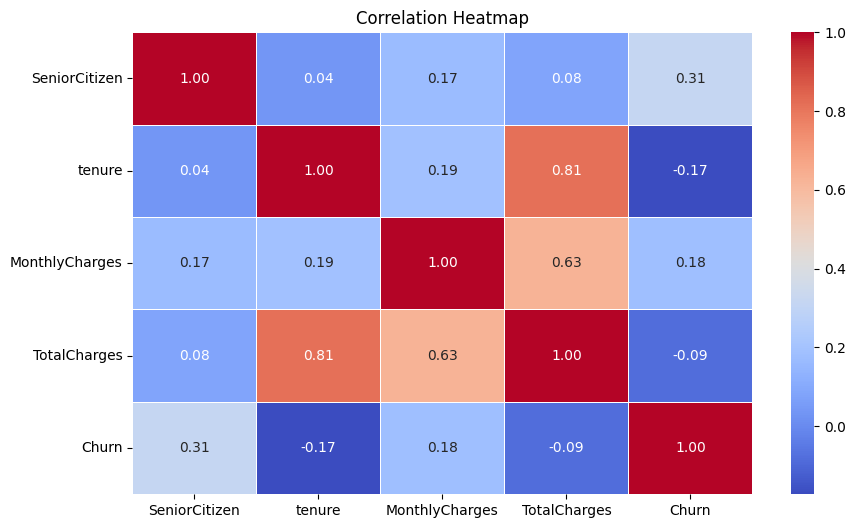

In [42]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


# Boxplot Analysis: TotalCharges
-After analyzing the boxplot, we observed that the outlier sample is very close to the box whiskers, so we decided not to remove it.

-Additionally, we noticed that the data is highly concentrated between 0 and the median (1659.1), indicating a strong density in this range.

-but from the median to the maximum the data is too sparse

-This confirms that the **TotalCharges** column is highly positively skewed—a key insight we tackled in Milestone #2

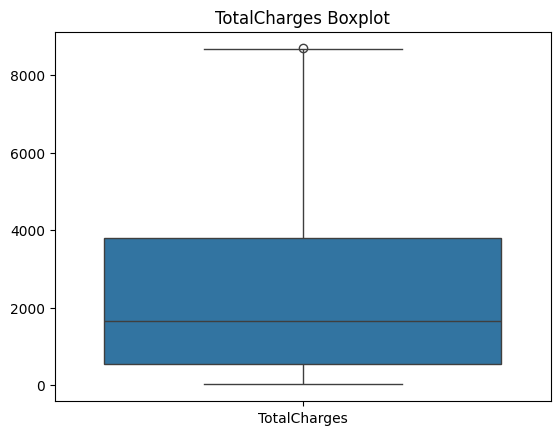

the median of the TotalCharges is : 1663.5
Skewness of TotalCharges: 0.8989248180986937


In [43]:
plt.figure()
sns.boxplot(data=df[['TotalCharges']])
plt.title("TotalCharges Boxplot")
plt.show()
print("the median of the TotalCharges is :",df["TotalCharges"].median())
print("Skewness of TotalCharges:", skew(df['TotalCharges']))

# Pairplot Analysis: MonthlyCharges, TotalCharges, and Tenure
-This pairplot visualizes the relationships between **MonthlyCharges**, **TotalCharges**, and **Tenure**, while also distinguishing between customers who **churned** (1) and **those who stayed** (0).

**TotalCharges** vs. **MonthlyCharges**: Shows a strong positive correlation, forming a triangular pattern due to TotalCharges being a cumulative value over tenure.

**Tenure** vs. **TotalCharges**: Clearly indicates that longer tenure customers tend to have higher total charges, reinforcing the expected trend.

**Tenure** vs. **MonthlyCharges**: Displays a more scattered distribution, suggesting that monthly charges vary significantly regardless of tenure.

**KDE Plots**(Diagonal): The density distributions show that churned customers (orange) tend to have lower tenure values, confirming that customers leaving the service often have shorter contracts(this info we also noticed in the visualization of **Contract** column).

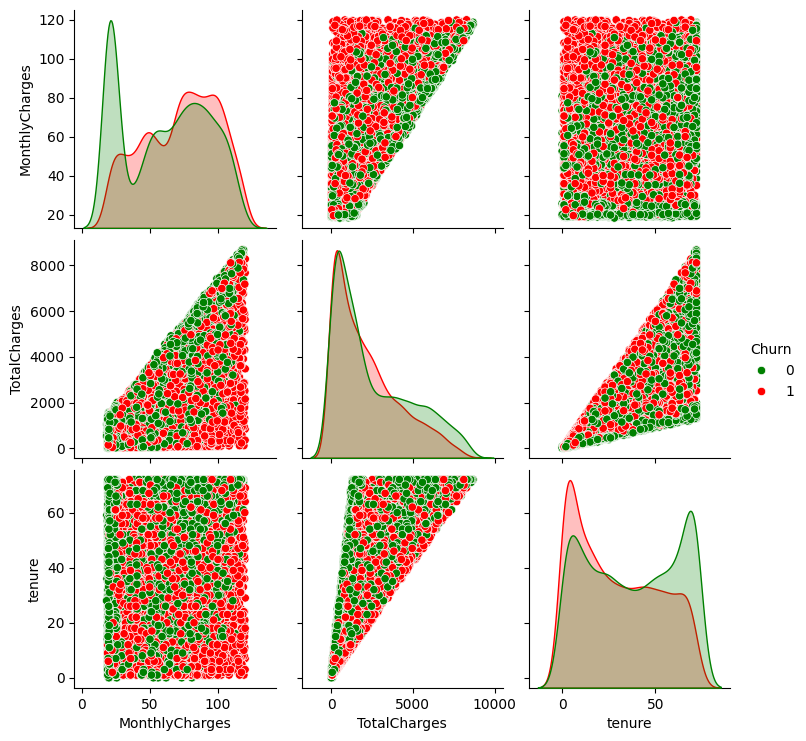

In [44]:
sns.pairplot(
    df[['MonthlyCharges', 'TotalCharges', 'tenure', 'Churn']],
    hue='Churn',
    palette={1: 'red', 0: 'green'}
)
plt.show()


# Monthly Charges Distribution Analysis
The **MonthlyCharges** values are approximately normally distributed, which is a good indication

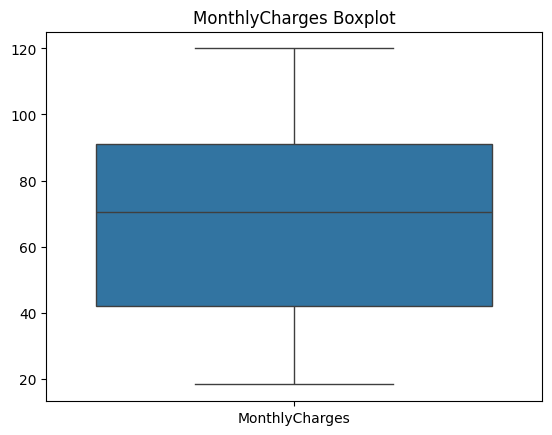

the median of the MonthlyCharges is : 70.4
Skewness of MonthlyCharges: -0.18054823535632783


In [45]:
sns.boxplot(data=df[['MonthlyCharges']])
plt.title("MonthlyCharges Boxplot")
plt.show()

print("the median of the MonthlyCharges is :",df["MonthlyCharges"].median())
print("Skewness of MonthlyCharges:", skew(df['MonthlyCharges']))

# Tenure Distribution Analysis
the **tenure** values are approximately normally distributed, which is a good indication

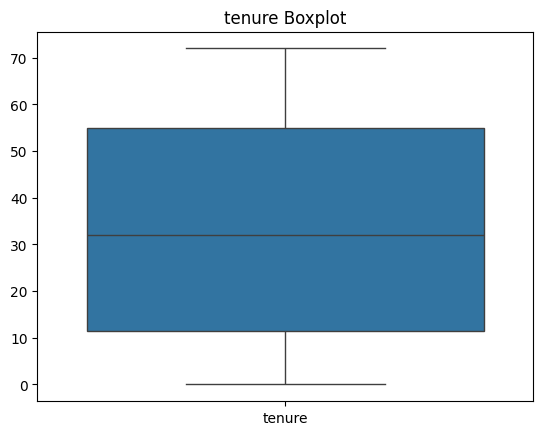

the median of the tenure is : 32.0
Skewness of tenure: 0.15202704765457298


In [46]:
sns.boxplot(data=df[['tenure']])
plt.title("tenure Boxplot")
plt.show()

print("the median of the tenure is :",df["tenure"].median())
print("Skewness of tenure:" , skew(df['tenure']))

# Impact of Contract Type on Churn Rate
As we previously mentioned, churn rate is **strongly** influenced by **contract type** —the **shorter** the contract, the **higher** the likelihood of **churn**!

**Month-to-Month** Contracts: Churned customers outnumber non-churned ones, indicating a high churn rate.

**Two Year** Contracts: Customers are highly likely to stay.

**One Year** Contracts: same as **Two Year** Contracts but with small diff between the Churned and non-Churned

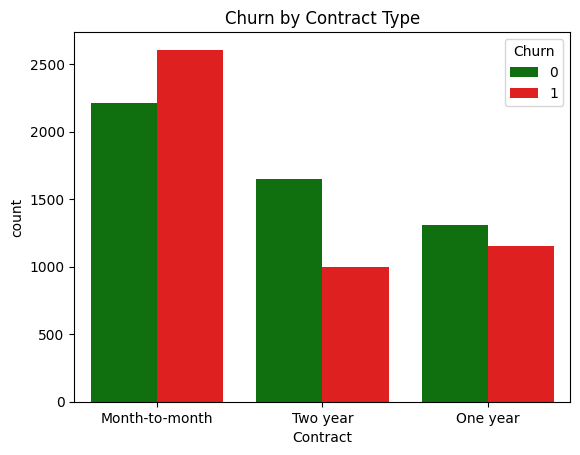

In [48]:
sorted_order = df['Contract'].value_counts().index

custom_palette = {0: 'green', 1: 'red'}

# Plot with sorted order
sns.countplot(data=df, x='Contract', hue='Churn', order=sorted_order, palette=custom_palette)
plt.title('Churn by Contract Type')
plt.show()

# Insights from Total Charges vs. Tenure (with respect to Churn)
**Customers with shorter tenure** (closer to 0)** have a much higher churn rate** (represented by red points). This suggests that new customers are more **likely to leave early**.

As **tenure increases**, **churn decreases—customers** with longer tenure (above 50) are predominantly **non-churned** (green points). This indicates customer retention improves over time.

**Higher Total Charges** are associated with **lower churn**, as customers with **high Total Charges tend to stay** (mostly green).

**The triangular shape** of the data suggests that **Total Charges increase** proportionally with **tenure**, which makes sense since customers accumulate more charges the longer they stay.

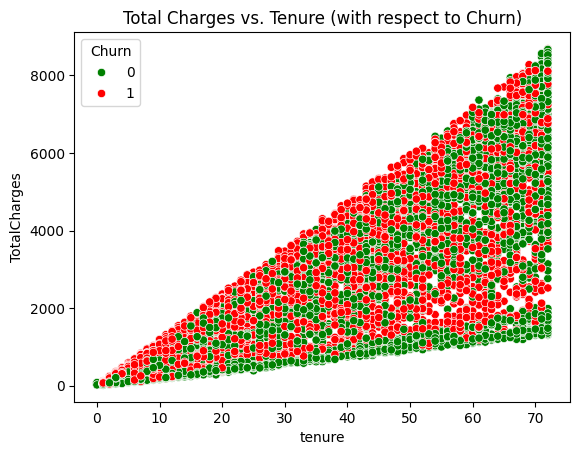

In [49]:
sns.scatterplot(
    data=df,
    x='tenure',
    y='TotalCharges',
    hue='Churn',
    palette={1: 'red', 0: 'green'}
)
plt.title("Total Charges vs. Tenure (with respect to Churn)")
plt.show()


# Monthly Charges & Churn Behavior
The distribution of **MonthlyCharges** reveals a key pattern:

Customers with **lower MonthlyCharges** are significantly more likely to stay (blue peak around ~$20).

On the other hand, **higher MonthlyCharges** are associated with an increased churn rate (red peak between ~$70–$100).

This indicates that pricing strategies can play a crucial role in customer retention!


<ipython-input-50-a9eeec492c92>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Churn"] == 0]["MonthlyCharges"], label="Not Churned", shade=True, color="blue")
<ipython-input-50-a9eeec492c92>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Churn"] == 1]["MonthlyCharges"], label="Churned", shade=True, color="red")


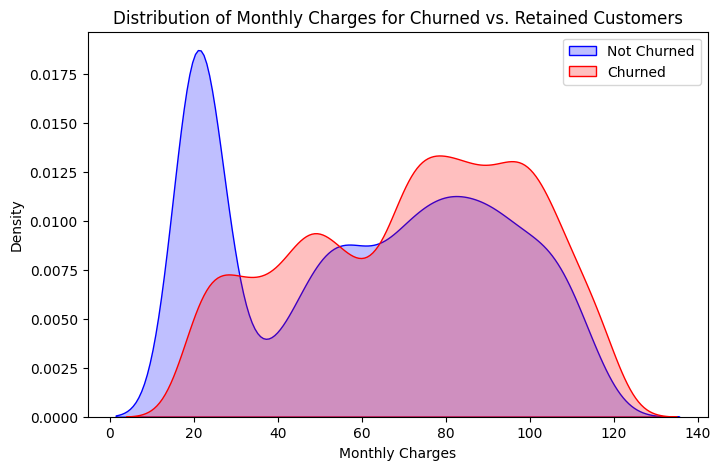

In [50]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["Churn"] == 0]["MonthlyCharges"], label="Not Churned", shade=True, color="blue")
sns.kdeplot(df[df["Churn"] == 1]["MonthlyCharges"], label="Churned", shade=True, color="red")
plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.title("Distribution of Monthly Charges for Churned vs. Retained Customers")
plt.legend()
plt.show()

# Tenure & Churn Probability
The distribution of Tenure indicaates that:

**Customers who churned** (red) tend to have much **shorter tenure**, mostly concentrated **below 20 months**.

In contrast, **long-term customers** (60+ months) have a much **lower churn rate** (blue).
This reinforces our previous insight – **customers with shorter contracts** or who are new to signing up are **more at risk of losing business**.

<ipython-input-51-d22348919ec8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Churn"] == 0]["tenure"], label="Not Churned", shade=True, color="blue")
<ipython-input-51-d22348919ec8>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Churn"] == 1]["tenure"], label="Churned", shade=True, color="red")


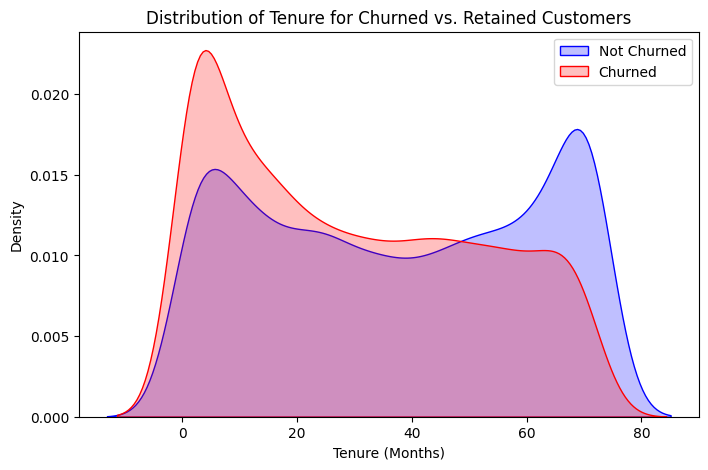

In [51]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["Churn"] == 0]["tenure"], label="Not Churned", shade=True, color="blue")
sns.kdeplot(df[df["Churn"] == 1]["tenure"], label="Churned", shade=True, color="red")
plt.xlabel("Tenure (Months)")
plt.ylabel("Density")
plt.title("Distribution of Tenure for Churned vs. Retained Customers")
plt.legend()
plt.show()

<ipython-input-52-d741c023a67e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Contract"], y=df["Churn"], order=["Month-to-month", "One year", "Two year"], palette="coolwarm")


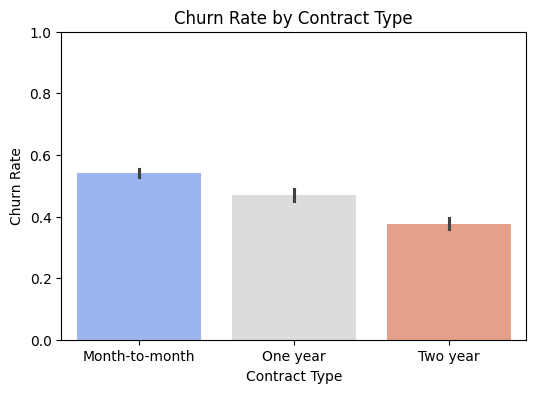

In [52]:
plt.figure(figsize=(6,4))
sns.barplot(x=df["Contract"], y=df["Churn"], order=["Month-to-month", "One year", "Two year"], palette="coolwarm")
plt.xlabel("Contract Type")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Contract Type")
plt.ylim(0, 1)
plt.show()

**Higher Churn in Early Tenure:**

A significant concentration of red points (churned customers) appears in the early tenure range (0–20 months).

**Churn Across Monthly Charges:**

Customers with higher Monthly Charges (above \$80–\$100) show a higher churn rate across different tenure levels.

**Churn Across Tenure:**

While churned customers exist across all tenure levels, their concentration decreases as tenure increases.
This aligns with the insight that longer-tenured customers are more loyal and less likely to leave.

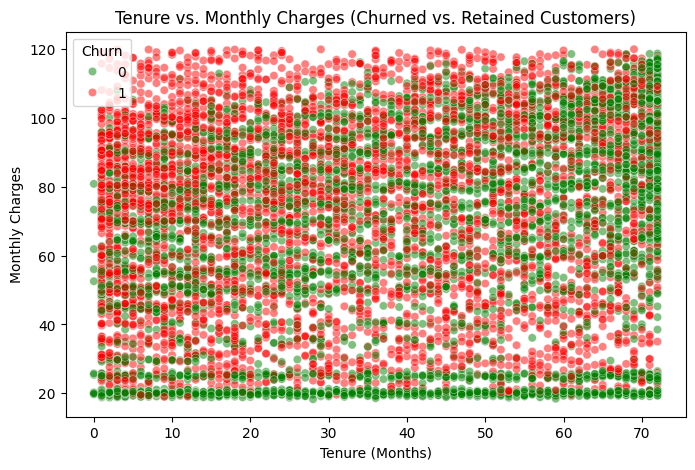

In [53]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["tenure"], y=df["MonthlyCharges"], hue=df["Churn"], alpha=0.5, palette={0: "green", 1: "red"})
plt.xlabel("Tenure (Months)")
plt.ylabel("Monthly Charges")
plt.title("Tenure vs. Monthly Charges (Churned vs. Retained Customers)")
plt.show()

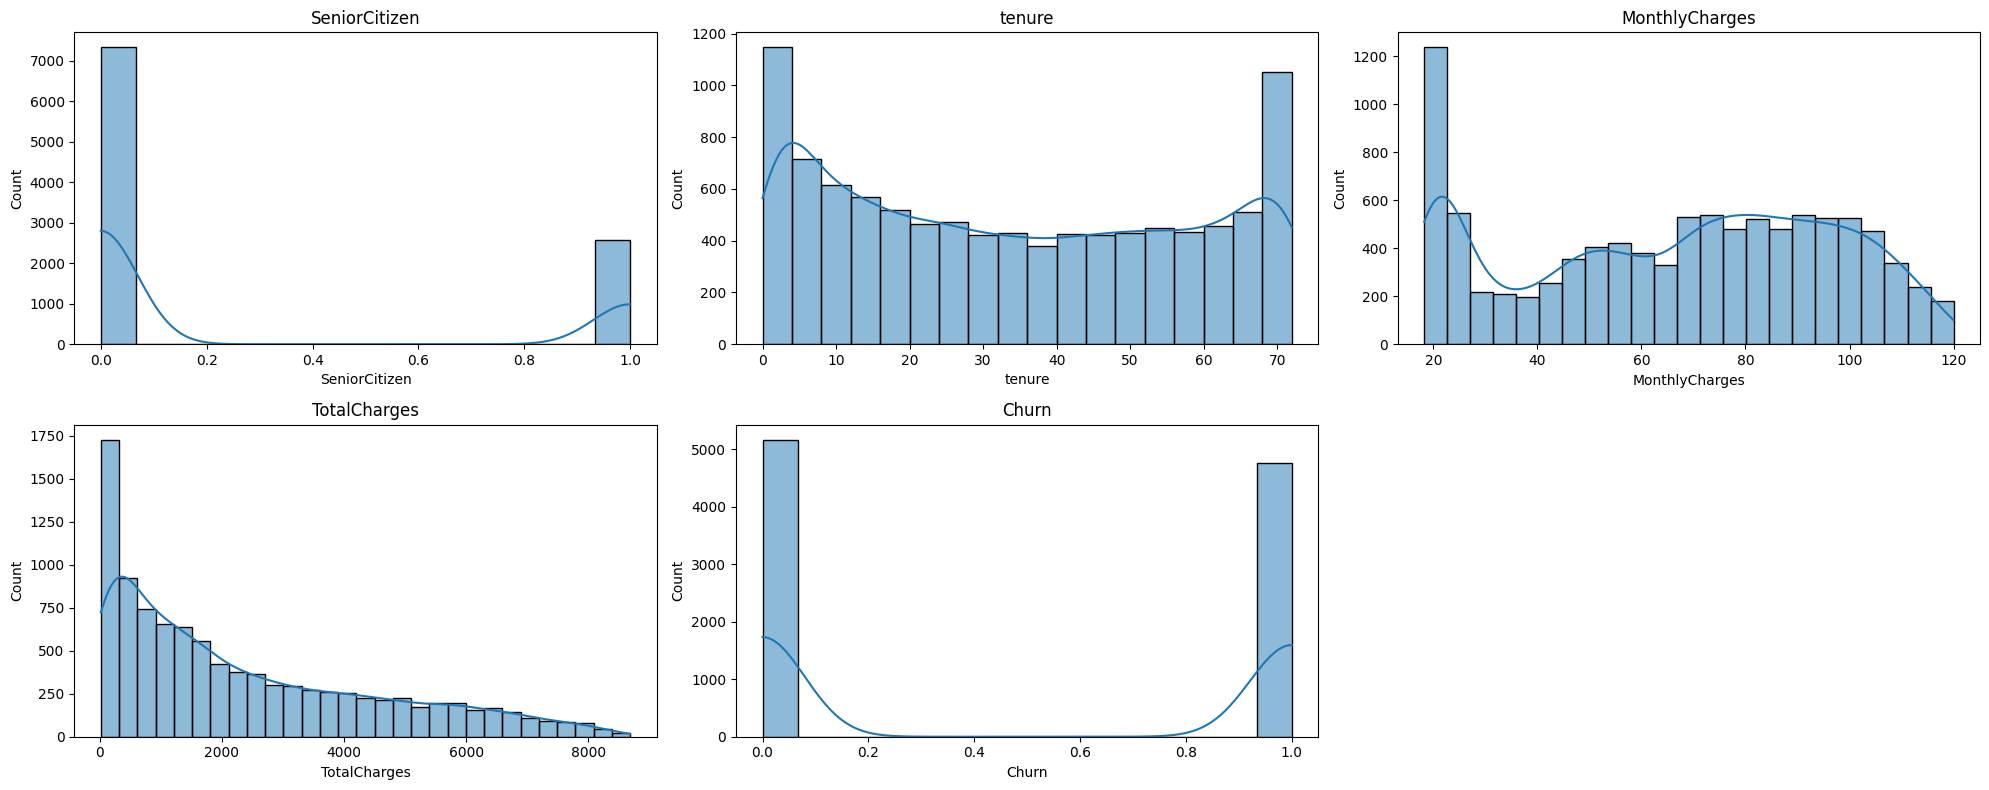

In [54]:
numeric_data = df.select_dtypes(include=np.number)

plt.figure(figsize=(20, 8))

# Calculate the number of rows needed for subplots dynamically
num_plots = len(numeric_data.columns)
rows = (num_plots // 3) + (num_plots % 3 > 0)  # Ensures enough rows

for e, i in enumerate(numeric_data.columns):
    plt.subplot(rows, 3, e + 1)  # Dynamically adjust the number of rows
    sns.histplot(numeric_data[i], kde=True)
    plt.title(i)

plt.tight_layout()
plt.show()


# Distribution of Customer Attributes

<ipython-input-22-47faedc95dcf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=i, data=c1, order=sorted_index, palette=custom_palette)
<ipython-input-22-47faedc95dcf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=i, data=c1, order=sorted_index, palette=custom_palette)
<ipython-input-22-47faedc95dcf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=i, data=c1, order=sorted_index, palette=custom_palette)
<ipython-input-22-47faedc95dcf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecat

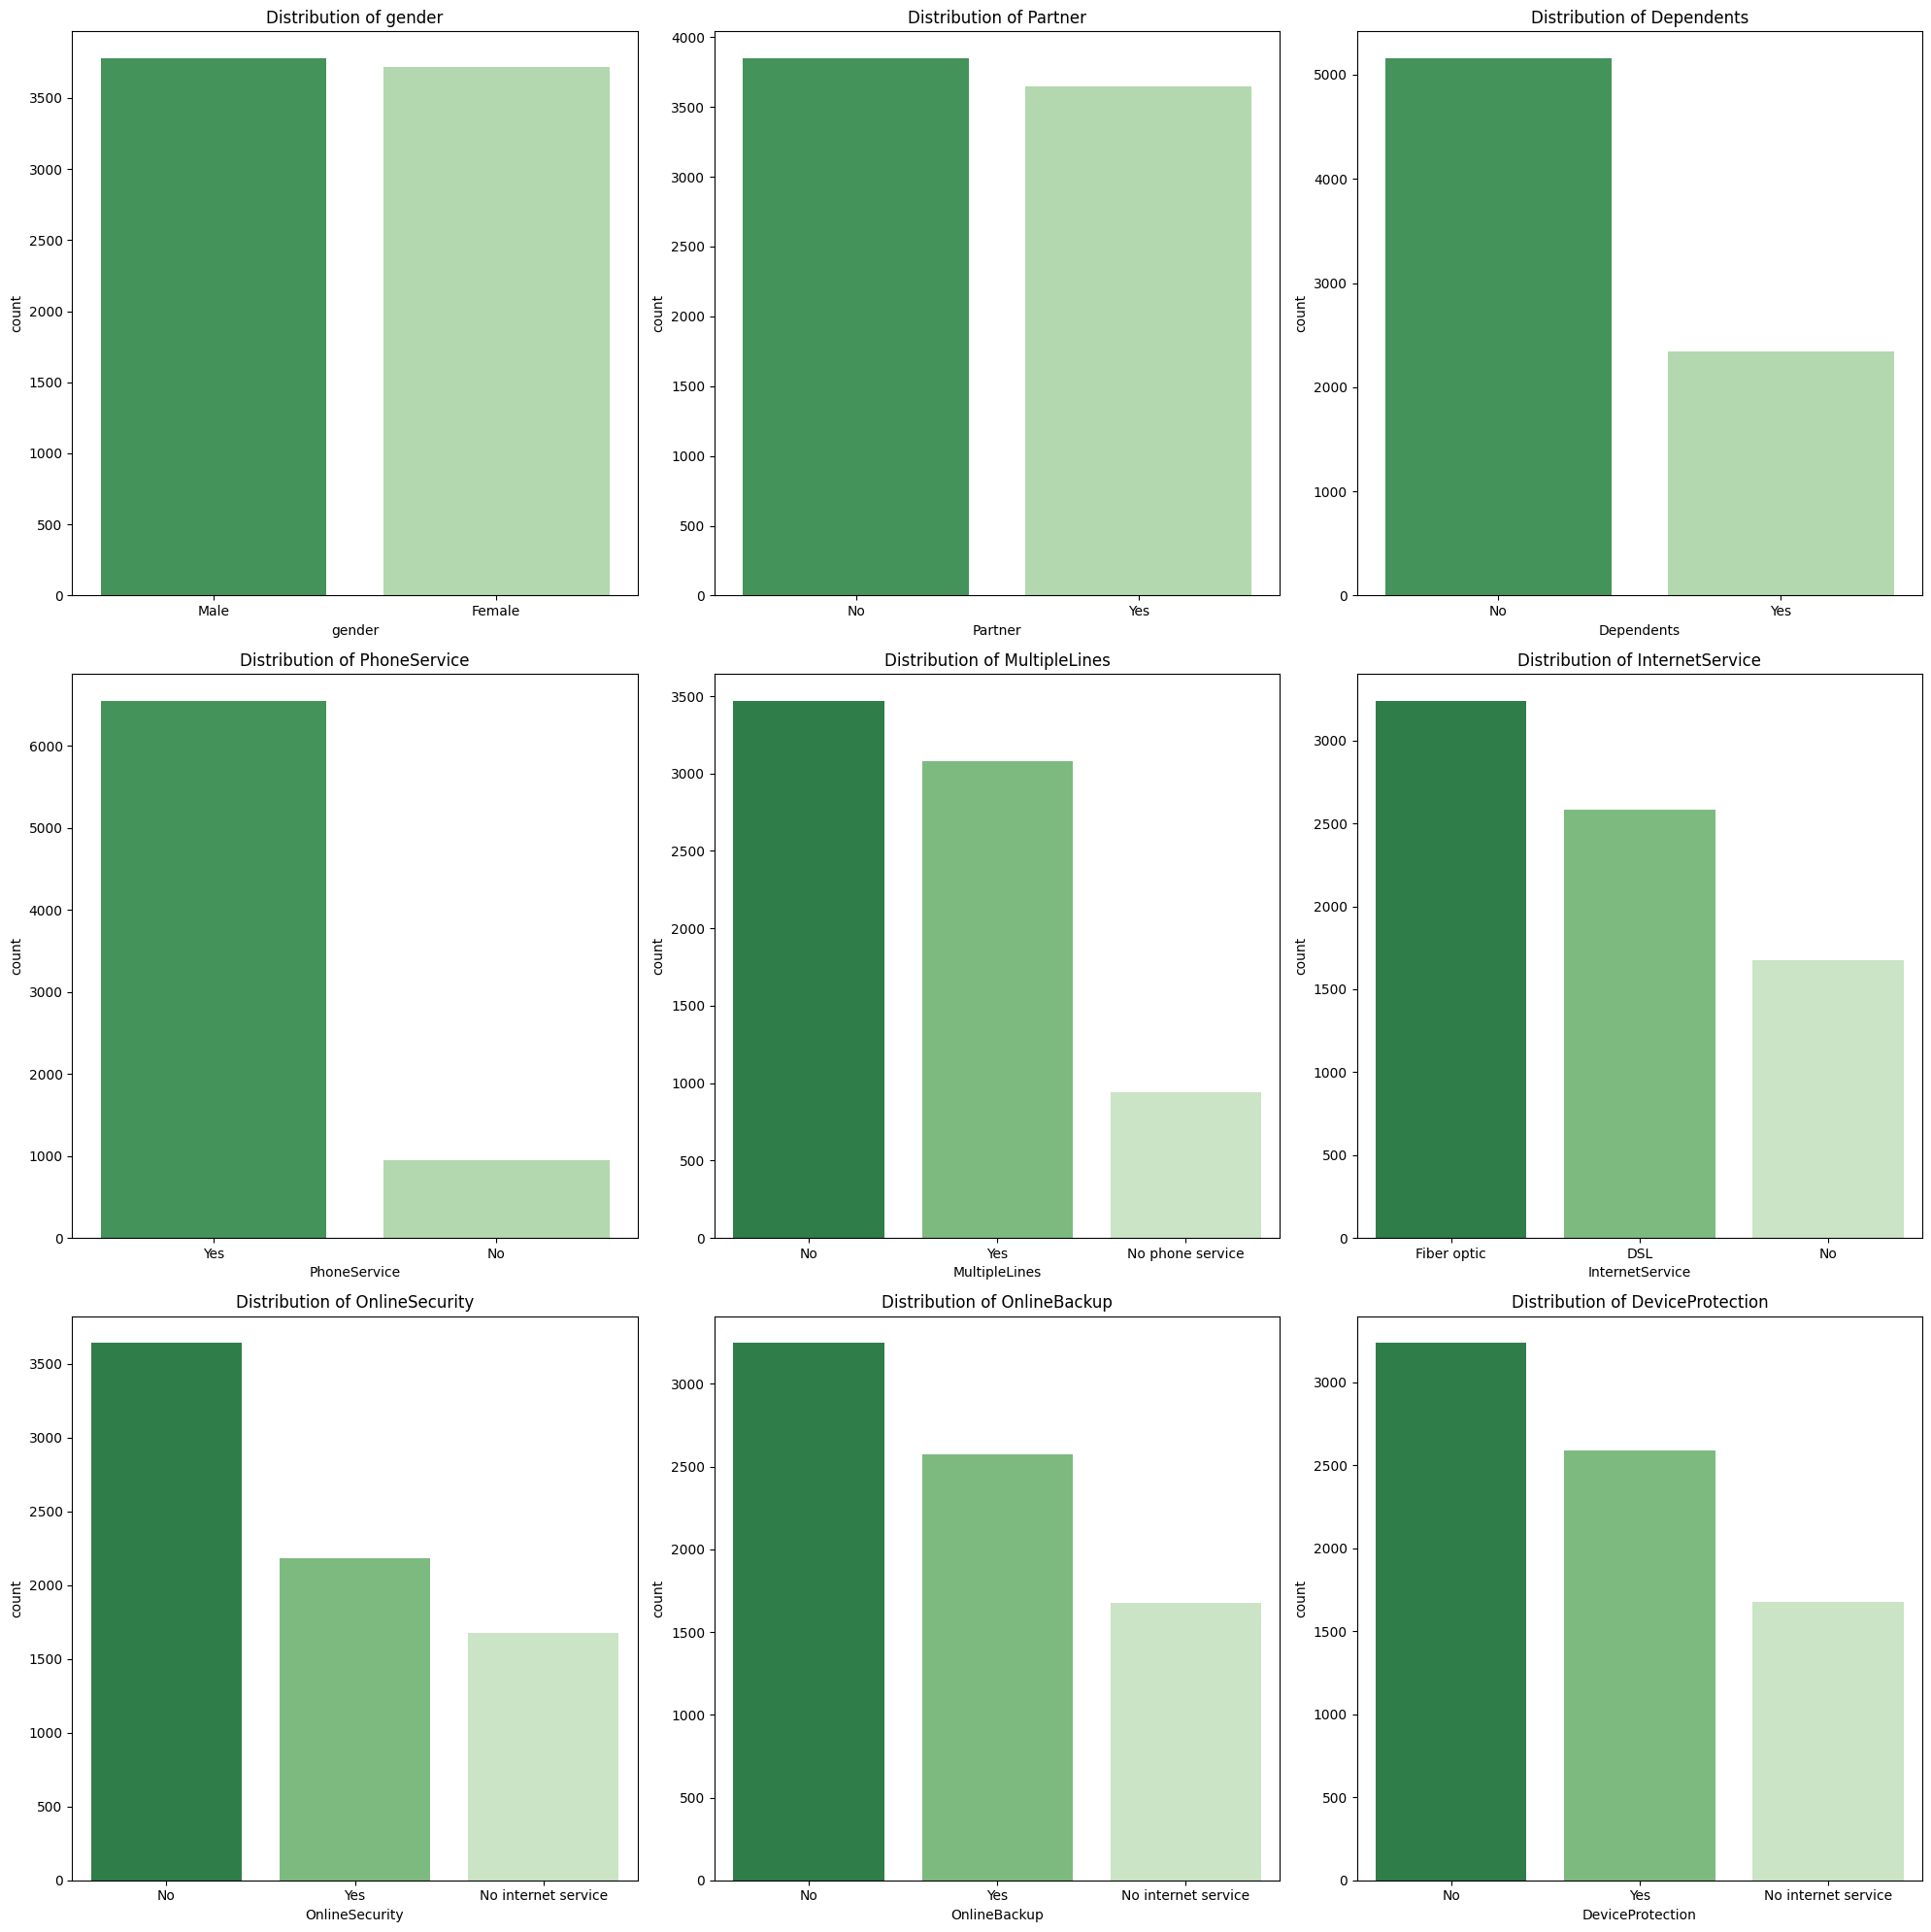

In [22]:
c1 = df[['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
         'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']]

plt.figure(figsize=(20, 20))
for e, i in enumerate(c1.columns):
    plt.subplot(3, 3, e + 1)

    # Get value counts and sort them (highest frequency first)
    value_counts = df[i].value_counts()
    sorted_index = value_counts.index

    # Generate colors based on frequency.
    # so that the highest frequency gets the darkest color.
    colors = sns.color_palette("Greens", len(value_counts))

    # Reverse the colors so that the highest count (first in sorted_index) gets the darkest color.
    custom_palette = dict(zip(sorted_index, colors[::-1]))

    # Create a bar plot with sorted order and custom colors
    ax = sns.countplot(x=i, data=c1, order=sorted_index, palette=custom_palette)

    plt.title(f"Distribution of {i}")

plt.tight_layout()
plt.show()

In [23]:
num_features = [
    'tenure', 'MonthlyCharges', 'TotalCharges'
]

scaler = StandardScaler()

# Fit and transform the data
df = df.copy()
df[num_features] = scaler.fit_transform(df[num_features])

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,1.610753,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),-1.508219,-0.437061,0
1,Male,0,Yes,No,1.159423,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,1.629634,2.146156,0
2,Male,0,No,No,-1.302377,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),-1.518217,-1.016554,0
3,Female,0,No,No,-1.261347,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),-1.494887,-1.009684,0
4,Female,0,No,No,0.626033,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),-1.354909,-0.489932,0
